In [25]:
import pandas as pd
import pyodbc as odbc

import helper_functions as hf

from dotenv import load_dotenv
from pathlib import Path
import os
env_path = Path.home()/'.env'
load_dotenv(dotenv_path= env_path, override=True)

import matplotlib.pyplot as plt
import numpy as np

DIR = os.getenv('budget_dir')

In [68]:
con, cur = hf.create_database_connection('budget')

### read transactions
transactions = pd.read_csv(DIR + 'transactions_test.csv')
unique_categories = transactions['Category']

### extract data from dimension tables
categories = hf.get_data('select * from categories_DIM', cur)
spending_groups = hf.get_data('select * from spending_groups_DIM', cur)
accounts = hf.get_data('select * from accounts_DIM', cur)
dates = hf.get_data('select * from Date_DIM', cur)

transactions
### update DB transactions table
spending_group_mapping = dict(spending_groups.iloc[:, [1, 0]].values)
category_mapping = dict(categories.iloc[:, [1, 0]].values)
account_mapping = dict(accounts.iloc[:, [2, 0]].values)
transactions['spending_group_key'] = transactions['Spending Group'].map(spending_group_mapping)
transactions['category_key'] = transactions['Category'].map(category_mapping)
transactions['account_key'] = transactions['Account'].map(account_mapping)
transactions['date_key'] = [x.replace('/', '') for x in transactions['Date']]
transactions.columns = transactions.columns.str.strip().str.lower()
transactions = transactions[['date_key', 'category_key', 'spending_group_key', 'account_key', 'description', 'amount']]

con, cur = hf.create_database_connection('budget')

for i, v in transactions.iterrows():
    cur.execute('INSERT INTO [dbo].[transactions_Fact] ([date_key], [category_key], [spending_group_key], [account_key], [description], [amount]) VALUES(?, ?, ?, ?, ?, ?)', v.date_key, v.category_key, v.spending_group_key, v.account_key, v.description, v.amount)
cur.commit()
con.commit()
cur.close()

AttributeError: 'Series' object has no attribute 'Date'

In [74]:
con, cur = hf.create_database_connection('budget')

transactions = pd.read_csv(DIR + 'transactions_test.csv')
transactions_STG = hf.get_data('select TOP 1 [upload_key] from transactions_STG ORDER BY 1 DESC' , cur)

transactions['Date'] = [x.replace('/', '') for x in transactions['Date']]
transactions['upload_key'] = 1
transactions.columns

for i, v in transactions.iterrows():
    cur.execute(f'''INSERT INTO [dbo].[transactions_STG] ([Date], [Description], [Account], [Spending Group], [Category], [Pay Month], [Split Transaction], [Amount], [Notes], [upload_key]) VALUES({v['Date']}, {v['Description']}, {v['Account']}, {v['Spending Group']}, {v['Category']}, {v['Pay Month']}, {v['Split Transaction']}, {v['Amount']}, {v['Notes']}, {v['upload_key']})''')
cur.commit()
con.commit()
cur.close()
con.close()



ProgrammingError: ('42000', "[42000] [Microsoft][ODBC SQL Server Driver][SQL Server]Incorrect syntax near 'Sa'. (102) (SQLExecDirectW)")

# Update dimension tables

In [7]:
### update DB dimension tables
con, cur = hf.create_database_connection('budget')

dimension_update_variables = {'categories':{'trxs_column_name': 'Category',
                                            'db_column_name': 'category_name',
                                            'db_tbl_name': 'categories_DIM'},
                              'spending_groups': {'trxs_column_name': 'Spending Group',
                                          'db_column_name': 'spending_group_name',
                                          'db_tbl_name': 'spending_groups_DIM'},
                              'accounts': {'trxs_column_name': 'Account',
                                          'db_column_name': 'account_detail',
                                          'db_tbl_name': 'accounts_DIM'}}

dimension_data = [categories, spending_groups, accounts]

# for the respective dimension
for i, v in enumerate(dimension_data):
    
    # unique list of categories from the new transactions
    trxs_values = list(transactions[list(dimension_update_variables.values())[i].get('trxs_column_name')].unique())

    # unique list of categories from the DB dimension table
    db_values = list(v[list(dimension_update_variables.values())[i].get('db_column_name')])

    # extract categories that are in the new transactions but not in the DB dimension table
    values_to_add = [x for x in trxs_values if x not in db_values]
    
    print(values_to_add)
    if len(values_to_add) > 0:
        for j, k in enumerate(values_to_add):
            query = f'''
                INSERT INTO [dbo].[{list(dimension_update_variables.values())[i].get('db_tbl_name')}] ([{list(dimension_update_variables.values())[i].get('db_column_name')}]) VALUES ('{k}');
                '''
            print(query)
            cur.execute(query)
            cur.commit()
            con.commit()
cur.close()
con.close()

['test category', 'Card Repayments', 'Uncategorised', 'Savings', 'Transport & Fuel', 'Eating Out & Takeaways', 'Insurance', 'Personal Care', 'Home Utility & Service', 'Phone & Internet', 'Entertainment', 'Coffee', 'Groceries', 'Home & Garden', 'Investments', 'Bank Charges & Fees', 'Clothing', 'Gifts', 'Interest', 'Vehicle Expenses', 'Medical', 'Sport & Fitness', 'Cellphone', 'Tech & Appliances', 'Friends & Family', 'Vehicle Loans', 'Loans']

                INSERT INTO [dbo].[categories_DIM] ([category_name]) VALUES ('test category');
                

                INSERT INTO [dbo].[categories_DIM] ([category_name]) VALUES ('Card Repayments');
                

                INSERT INTO [dbo].[categories_DIM] ([category_name]) VALUES ('Uncategorised');
                

                INSERT INTO [dbo].[categories_DIM] ([category_name]) VALUES ('Savings');
                

                INSERT INTO [dbo].[categories_DIM] ([category_name]) VALUES ('Transport & Fuel');
        

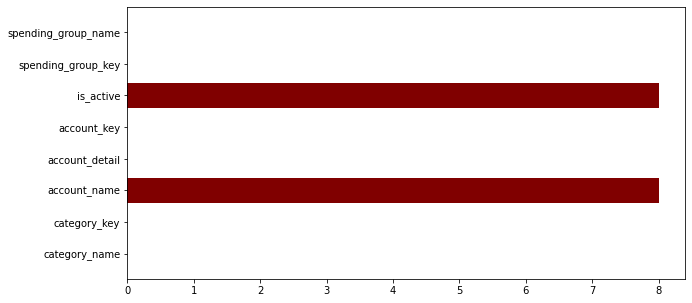

In [11]:
con, cur = hf.create_database_connection('budget')

### completeness
query = 'select * from dq_completeness'
nulls = hf.get_data(query, cur)

fig = plt.figure(figsize = (10, 5))
dq_completeness = plt.barh(nulls['attribute'], nulls['count_null_records'], color='maroon')

In [21]:
plt.show(dq_completeness)